# Geospatial data exercise

In [1]:
#!pip list

In [2]:
#!pip install geopandas

In [3]:
#Using python 3.8.5
import warnings

warnings.filterwarnings("ignore") #just to keep clean

from zipfile import ZipFile
import requests
import geopandas as gpd
import numpy as np
import math
from os import path
from matplotlib.pyplot import rcParams
import plotly.express as px
import plotly.io as pio


rcParams["figure.figsize"]=(8,8)
pio.renderers.default="browser"

source=r'https://statbel.fgov.be/sites/default/files/files/opendata/ \
Statistische%20sectoren/sh_statbel_statistical_sectors_20200101.shp.zip'
file_name=source.split("/")[-1][:-4]
print("The file that is downloaded is :")
print(file_name)


The file that is downloaded is :
sh_statbel_statistical_sectors_20200101.shp


In [4]:
# Get data from source if it is not available
def get_data(source):
    if path.exists(file_name):
        pass
    else:
        response=requests.get(source,stream=True)
        zz =ZipFile(io.BytesIO(response.content))
        zz.extractall()
        
get_data(source) 

## Read in the shape file

<AxesSubplot:>

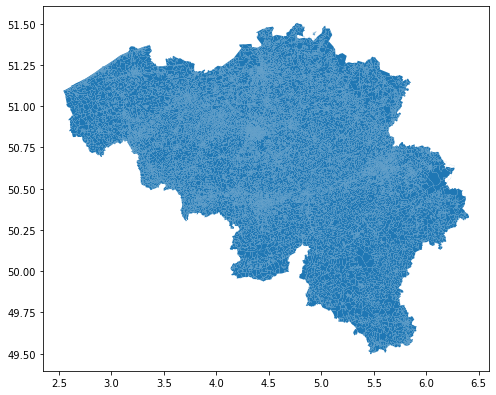

In [5]:
#reading the file
df=gpd.read_file(file_name)
df = df.to_crs({'init': 'epsg:4326'})
df.plot()

In [6]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19794 entries, 0 to 19793
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CS01012020  19794 non-null  object  
 1   T_SEC_NL    19751 non-null  object  
 2   T_SEC_FR    19751 non-null  object  
 3   T_SEC_DE    19751 non-null  object  
 4   C_NIS6      19794 non-null  object  
 5   T_NIS6_NL   19794 non-null  object  
 6   T_NIS6_FR   19794 non-null  object  
 7   CNIS5_2020  19794 non-null  object  
 8   T_MUN_NL    19794 non-null  object  
 9   T_MUN_FR    19794 non-null  object  
 10  T_MUN_DE    19794 non-null  object  
 11  C_ARRD      19794 non-null  object  
 12  T_ARRD_NL   19794 non-null  object  
 13  T_ARRD_FR   19794 non-null  object  
 14  T_ARRD_DE   19794 non-null  object  
 15  C_PROVI     19794 non-null  object  
 16  T_PROVI_NL  19070 non-null  object  
 17  T_PROVI_FR  19070 non-null  object  
 18  T_PROVI_DE  19070 non-null  object  
 

In [7]:
#Dropping unwanted cols
df=df.drop(["T_PROVI_FR","T_PROVI_DE","T_SEC_FR","T_SEC_DE","T_NIS6_FR","T_MUN_FR", \
            "T_MUN_DE","T_ARRD_FR","T_ARRD_DE","T_REGIO_FR","T_REGIO_DE"],axis=1)

In [8]:
# optimizing the code
df['centroid_lon'],df['centroid_lat']=df.geometry.centroid.x,df.geometry.centroid.y

In [9]:
df[['centroid_lon','centroid_lat']].describe() # to check the column data

,centroid_lon,centroid_lat
count,19794.000000,19794.000000
mean,4.568883,50.706348
std,0.815366,0.372493
min,2.564607,49.508280
25%,4.033413,50.462349
50%,4.516874,50.746292
75%,5.242009,50.983725
max,6.382802,51.496173


## Create a distance function (Haversine)

In [10]:
#Creating Distance function

def haversine(home_lon,home_lat,dest_lon,dest_lat):
    earth_radius=6371 # (mean)radius of earth in km
    
    psi_1 = math.radians(home_lat)
    psi_2 = math.radians(dest_lat)
    
    delta_psi = math.radians(dest_lat - home_lat)
    delta_lamda = math.radians(dest_lon - home_lon)
    
    factor_1=math.sin(delta_psi / 2.0) ** 2 + math.cos(psi_1) * math.cos(psi_2) * math.sin(delta_lamda / 2.0) ** 2
    
    factor_2 = 2 * math.atan2(math.sqrt(factor_1), math.sqrt(1 - factor_1))
    
    result_km = round(earth_radius*factor_2,3)
    return result_km    

## Create variables for home_lat, home_lon and perimeter_distance

In [11]:
def pick_a_location(i=2130):
    current_selection=df.iloc[i]
    return current_selection

#picking a random home location, by default i=2130

#res =pick_a_location()
index_loc=np.random.randint(0,len(df)-1)
res = pick_a_location(index_loc)

# Create variables for home_lat, home_lon and perimeter_distance

home_lon,home_lat=res[['centroid_lon','centroid_lat']].tolist()
home_regio=res["T_REGIO_NL"]
home_province=res["T_PROVI_NL"]

print("Home location longitude : {0} and latitude : {1} \n Located at {2},{3}" \
      .format(home_lon,home_lat,home_regio,home_province))

perimeter_distance = 2 # km

Home location longitude : 4.832457920276775 and latitude : 51.05905252911522 
 Located at Vlaams Gewest,Provincie Antwerpen


In [12]:
#Distance check, Division by zero error check!

a1,b1,a2,b2=3.7633068006136714,51.24586877258507,4.655864007354974,51.35176606114798
#a1,b1,a2,b2=4.143757929030797,51.155958067210804,4.143757929030797,51.155958067210804
#a1,b1,a2,b2=3.463300119852554,51.068841565883204,4.377073533455338,50.36478110425794
res=haversine(a1,b1,a2,b2)
res

63.162

## Calculate the distance to home for each nis district centroid

In [13]:
# creating 2 new colums to include home longitude,latitude
df["home_lon"]=home_lon
df["home_lat"]=home_lat

df["haversine_dist_4m_home"]=df.apply(lambda x:haversine(x["home_lon"],x["home_lat"], \
                                                         x["centroid_lon"],x["centroid_lat"]),\
                                      axis=1)

## Figure out which nis districts are near your home

In [14]:
# ============== Aid for visualization ==============
def dist_cmap(x):
    result = "Out_of_perimeter"
    
    if x==0.0:
        result= "Home"
    elif 0.0 < x <= perimeter_distance:
        result = "Within_perimeter"
    elif perimeter_distance < x <= 2*perimeter_distance:
        result ="2*perimeter_distance"
    elif 2*perimeter_distance< x <= 5*perimeter_distance:
        result="5*perimeter_distance"
    else:
        result=">5*perimeter_distance"
        
    return result

df["How_far_4m_home"]=df.apply(lambda x:dist_cmap(x["haversine_dist_4m_home"]),axis=1)

In [15]:
df["haversine_dist_4m_home"].head()

0    32.041
1    32.508
2    33.192
3    32.867
4    32.116
Name: haversine_dist_4m_home, dtype: float64

In [16]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19794 entries, 0 to 19793
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CS01012020              19794 non-null  object  
 1   T_SEC_NL                19751 non-null  object  
 2   C_NIS6                  19794 non-null  object  
 3   T_NIS6_NL               19794 non-null  object  
 4   CNIS5_2020              19794 non-null  object  
 5   T_MUN_NL                19794 non-null  object  
 6   C_ARRD                  19794 non-null  object  
 7   T_ARRD_NL               19794 non-null  object  
 8   C_PROVI                 19794 non-null  object  
 9   T_PROVI_NL              19070 non-null  object  
 10  C_REGIO                 19794 non-null  object  
 11  T_REGIO_NL              19794 non-null  object  
 12  C_COUNTRY               19794 non-null  object  
 13  NUTS1                   19794 non-null  object  
 14  NUTS2         

In [17]:
df.iloc[index_loc]

CS01012020                                                        13016B000
T_SEC_NL                                                  WESTMEERBEEK-KERN
C_NIS6                                                               13016B
T_NIS6_NL                                                      WESTMEERBEEK
CNIS5_2020                                                            13016
T_MUN_NL                                                           Hulshout
C_ARRD                                                                13000
T_ARRD_NL                                           Arrondissement Turnhout
C_PROVI                                                               10000
T_PROVI_NL                                              Provincie Antwerpen
C_REGIO                                                               02000
T_REGIO_NL                                                    Vlaams Gewest
C_COUNTRY                                                                BE
NUTS1       

In [18]:
# ============== Aid for visualization ==============
def normalize_dist(x):
    #var1=(x-df["haversine_dist_4m_home"].min())
    #var2=(df["haversine_dist_4m_home"].max()-df["haversine_dist_4m_home"].min())
    #result=round(var1/var2,1)
    if x == 0.0:
        res=0
    elif 0.0 < x <= perimeter_distance:
        res=4
    elif perimeter_distance < x <= 2*perimeter_distance:
        res=6
    elif 2*perimeter_distance < x <5*perimeter_distance:
        res=8
    else:
        res=10
    return res

df["distance_scale"]=df["haversine_dist_4m_home"].apply(lambda x : normalize_dist(x))

df["distance_scale"].describe()

count    19794.000000
mean         9.979287
std          0.239940
min          0.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: distance_scale, dtype: float64

## Create dynamic zoomable map

In [19]:
#Visualizing the nis districts(centroid <2km away), on the map

fig = px.choropleth_mapbox(df,
                           hover_name=(df.CS01012020+"__"+df.How_far_4m_home),
                           geojson=df.geometry,
                           hover_data=[df.T_SEC_NL,
                                       df.T_NIS6_NL,
                                       df.T_ARRD_NL,
                                       df.T_REGIO_NL,
                                       df.NUTS3,
                                       df.M_AREA_HA,
                                       df.centroid_lat,df.centroid_lon,
                                       df.haversine_dist_4m_home],
                           locations=df.index,
                           color=df.distance_scale,
                           opacity=0.25,
                           zoom=15,mapbox_style="carto-positron",
                           center ={"lat":home_lat,"lon":home_lon})

fig.show()